In [2]:
import numpy as np

x = np.load("/project/msoleyma_1026/ecp/data/pair_embeddings/concatenated/train-emotion/conv_18_utterance_pair_9_2.npy")
print(x.shape)

(1, 5120)


In [3]:
import sklearn; print(sklearn.__version__)

1.2.2


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [5]:
with open('/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json', 'r') as f:
    data = json.load(f)

In [6]:
class_one_count = 0
class_zero_count = 0
for conv in data:
    for key, value in conv.items():
        for utterance_pair in value:
            if utterance_pair['valid_pair'] == 1:
                class_one_count += 1
            elif utterance_pair['valid_pair'] == 0:
                class_zero_count += 1
                
print(class_zero_count)
print(class_one_count)
# class_counts = torch.tensor([class_zero_count, class_one_count])
# weight = 1.0 / class_counts.float()
# class_weights = weight / weight.sum()
pos_weight = torch.tensor(class_zero_count).float() / torch.tensor(class_one_count).float()
pos_weight, pos_weight.shape

37081
7621


(tensor(4.8656), torch.Size([]))

In [7]:
pos_weight

tensor(4.8656)

In [8]:
def debug_collate_fn(batch):
    batch_tensors = []
    convIDs = []
    utterancePairs = []
    for item in batch:
        tensor_data = item[:2]
        batch_tensors.append(tensor_data)
        convIDs.append(item[2])
        utterancePairs.append(item[3])

    try:
        tensor_batch = torch.utils.data.dataloader.default_collate(batch_tensors)
    except RuntimeError as e:
        print("Error during tensor collation. Printing tensor sizes:")
        for idx, (inputs, labels) in enumerate(batch_tensors):
            print(f"Item {idx} - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
        raise e

    return (*tensor_batch, convIDs, utterancePairs)

class PairDataset(Dataset):
    def __init__(self, data_file, embeddings_dir, mode='train'):
        self.data_file = data_file
        self.embeddings_dir = embeddings_dir
        self.mode = mode
        self.pairs = self.load_pairs()
        self.emotion_list = sorted(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise'])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.emotion_list)
        self.one_hot_encoder = OneHotEncoder(sparse=False)
        self.one_hot_encoder.fit(np.array(self.emotion_list).reshape(-1, 1))
        if self.mode == 'eval':
            self.predicted_emotions = self.load_predicted_emotions()

    def __len__(self):
        return len(self.pairs)

    def load_pairs(self):
        with open(self.data_file, 'r') as file:
            pairs = json.load(file)
        return pairs

    def load_predicted_emotions(self):
        with open('/project/msoleyma_1026/ecp/data/predictions/early_fusion_predictions.json', 'r') as file:
            predictions = json.load(file)
        prediction_dict = {}
        for conversation in predictions:
            conversation_id = conversation['conversation_id']
            for utterance in conversation['utterances']:
                utterance_id = utterance['utt_id']
                emotion = utterance['emotion']
                if conversation_id not in prediction_dict:
                    prediction_dict[conversation_id] = {}
                prediction_dict[conversation_id][utterance_id] = emotion
        return prediction_dict

    def load_embeddings(self, conv_id, utterance_pair_ids):
        primary_dir = self.embeddings_dir

        file_name = f"conv_{conv_id}_utterance_pair_{utterance_pair_ids[0]}_{utterance_pair_ids[1]}.npy"
        primary_embedding_file = os.path.join(primary_dir, file_name)

        if os.path.exists(primary_embedding_file):
          embedding = np.load(primary_embedding_file)
        else:
          raise FileNotFoundError(f"Embedding file not found for {file_name}")
        return torch.from_numpy(embedding).float().view(1, -1)

    def __getitem__(self, idx):
      try:
        conv_pairs = self.pairs[idx]
        context_embeddings = []
        pair_labels = []
        utterancePairList = []
        emotions = []

        first_conversation_id = next(iter(conv_pairs))
        for utterance_pair in conv_pairs[first_conversation_id]:
            utterance_pair_ids = utterance_pair['utterance_pair']
            utterancePairList.append(utterance_pair_ids)
            if self.mode == 'train':
                emotions.append(utterance_pair['emotion'])
            elif self.mode == 'eval':
                emotions.append(self.predicted_emotions[int(first_conversation_id)][int(utterance_pair_ids[0])])
        if self.mode == 'eval':
            emotions = self.label_encoder.inverse_transform(emotions).tolist()

        encoded_emotions = self.one_hot_encoder.transform(np.array(emotions).reshape(-1, 1))

        encoded_emotions_tensor = torch.tensor(encoded_emotions, dtype=torch.float32)

        context_embeddings = [self.load_embeddings(first_conversation_id, utt['utterance_pair']).float() for utt in conv_pairs[first_conversation_id]]
        
        for i in range(len(context_embeddings)):
            reshaped_encoded_emotions = encoded_emotions_tensor[i].view(1, -1)
            concatenated_embedding = torch.cat((context_embeddings[i], reshaped_encoded_emotions), dim=1)
            context_embeddings[i] = concatenated_embedding
        pair_labels = [utt['valid_pair'] for utt in conv_pairs[first_conversation_id]]

        if self.mode == 'train':
            max_seq_length = 253
        elif self.mode == 'eval':
            max_seq_length = 561
        num_to_add = 0
        padded_embeddings = []
        if len(context_embeddings) < max_seq_length:
            num_to_add = max_seq_length - len(context_embeddings)
            zero_tensor = torch.zeros((1,5127), dtype=torch.float32)
            context_embeddings += [zero_tensor] * num_to_add
        context_embeddings_padded = torch.cat(context_embeddings, dim=0)
        pair_labels += [-1] * num_to_add
        pair_labels_tensor = torch.tensor(pair_labels, dtype=torch.float32)

        return context_embeddings_padded, pair_labels_tensor, first_conversation_id, utterancePairList
      except Exception as e:
        print(f"Error loading item {idx}: {e}")
        raise e


class PairDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_emotions, n_layers=2, dropout=0.2):
        super(PairDetector, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_emotions = num_emotions
        self.n_layers = n_layers

        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=n_layers)

        self.decoder_emotion = nn.Linear(input_dim, num_emotions)

    def forward(self, context_embeddings):
        encoded_context = self.transformer_encoder(context_embeddings)
        prediction_emotion = self.decoder_emotion(encoded_context)  # (batch_size, seq_length, num_emotions)
        return prediction_emotion.squeeze()

In [9]:
input_size = 5127
hidden_size = 4096
num_classes = 1
lr = 1e-5
batch_size = 64
num_epochs = 20
num_layers = 3
print_interval = 5

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/concatenated/train-emotion'

train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.0).float()) 

total_loss = 0.0
total_batches = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss_emotion = 0.0
    num_batches = 0
    for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()

        active_outputs = outputs[labels != -1]
        active_pairs = labels[labels != -1]
        loss = criterion(active_outputs, active_pairs)
        loss.backward()
        optimizer.step()

        epoch_loss_emotion += loss.item()
        total_loss += loss.item()
        total_batches += 1
        # print(loss.item())

        if (batch_idx + 1) % print_interval == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}')

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

overall_avg_loss = total_loss / total_batches
print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

torch.save(model.state_dict(), '/project/msoleyma_1026/ecp/models/pair_detection_model_early.pt')

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.2679
Epoch [1/20], Batch [10/17], Loss: 1.1246
Epoch [1/20], Batch [15/17], Loss: 1.1424
Epoch 1/20, Loss: 1.2449
Epoch [2/20], Batch [5/17], Loss: 0.9886
Epoch [2/20], Batch [10/17], Loss: 1.0287
Epoch [2/20], Batch [15/17], Loss: 1.0117
Epoch 2/20, Loss: 1.0218


KeyboardInterrupt: 

In [12]:
model = PairDetector(5127, 4096, 1, n_layers=3)
model.load_state_dict(torch.load('/project/msoleyma_1026/ecp/models/pair/early/pair_detection_model_early4.0.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


PairDetector(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=5127, out_features=5127, bias=True)
        )
        (linear1): Linear(in_features=5127, out_features=4096, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=4096, out_features=5127, bias=True)
        (norm1): LayerNorm((5127,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((5127,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder_emotion): Linear(in_features=5127, out_features=1, bias=True)
)

In [13]:
def evaluate_model_for_roc(model, dataloader, device):
    model.eval()
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, _, _ = batch  # Adjust based on your actual data structure
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            
            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()

            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            sigmoid_output = torch.sigmoid(active_outputs)            

            # Initialize valid_scores and valid_labels as empty tensors
            valid_scores = torch.tensor([], device=device)
            valid_labels = torch.tensor([], device=device)

            # Ensure the shapes are correct for indexing
            valid_scores = sigmoid_output
            valid_labels = active_pairs
            
            all_scores.extend(valid_scores.cpu().tolist())
            all_labels.extend(valid_labels.cpu().tolist())

    return all_scores, all_labels


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


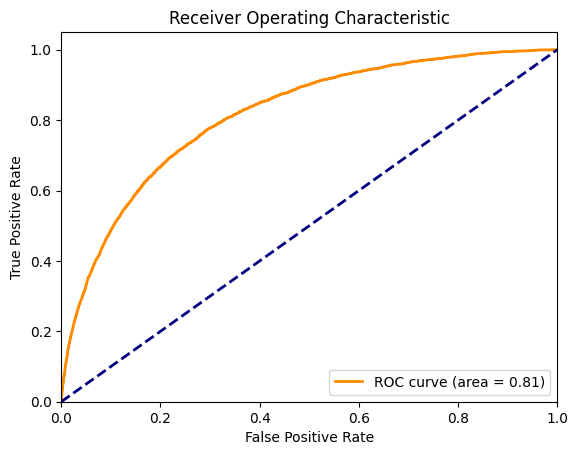

In [14]:
# Assuming you have collected all_scores and all_labels from your dataset
pairs_labels_file_roc = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
embeddings_dir_roc = '/project/msoleyma_1026/ecp/data/pair_embeddings/concatenated/train-emotion'
train_dataset_roc = PairDataset(pairs_labels_file_roc, embeddings_dir_roc, mode='train')
train_loader_roc = DataLoader(train_dataset_roc, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)
scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Calculate the optimal threshold: the one with the highest tpr - fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)

Optimal threshold: 0.6167736649513245


In [16]:
import json
import torch
from torch.utils.data import DataLoader


def load_predicted_emotions(json_filepath):
    #print(f"Loading predicted emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file)
    predicted_emotions_dict = {}
    for conversation in data:
        conversation_id = str(conversation['conversation_id'])
        for utterance in conversation['utterances']:
            utterance_id = str(utterance['utt_id'])
            emotion = utterance['emotion']
            if conversation_id not in predicted_emotions_dict:
                predicted_emotions_dict[conversation_id] = {}
            predicted_emotions_dict[conversation_id][utterance_id] = emotion
    #print("Predicted Emotions Loaded")
    return predicted_emotions_dict

def load_true_emotions(json_filepath):
    #print(f"Loading true emotions from {json_filepath}")
    with open(json_filepath, 'r') as file:
        data = json.load(file) 
    true_emotions_dict = {}
    for conversation_data in data:  
        for conversation_id, utterance_pairs in conversation_data.items():
            if conversation_id not in true_emotions_dict:
                true_emotions_dict[conversation_id] = {}
            for utterance_info in utterance_pairs:
                utterance_pair = utterance_info['utterance_pair']
                emotion = utterance_info['emotion']
                first_utterance_id = str(utterance_pair[0])  # First element of the utterance pair
                true_emotions_dict[conversation_id][first_utterance_id] = emotion
    #print("True Emotions Loaded")
    return true_emotions_dict

def filter_predicted_emotions(predicted_emotions_dict, true_emotions_dict):
    filtered_dict = {}
    for conv_id, utterances in predicted_emotions_dict.items():
        if conv_id in true_emotions_dict:
            filtered_dict[conv_id] = {}
            for utt_id in utterances:
                if utt_id in true_emotions_dict[conv_id]:
                    filtered_dict[conv_id][utt_id] = predicted_emotions_dict[conv_id][utt_id]
    return filtered_dict

from sklearn.preprocessing import LabelEncoder

def encode_emotions(emotions_dict):
    encoder = LabelEncoder()
    emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    encoder.fit(emotion_labels)
    encoded_dict = {}
    for conv_id, utterances in emotions_dict.items():#
        encoded_dict[conv_id] = {}
        for utt_id, emotion in utterances.items():
            if emotion in emotion_labels:  # Only encode if the emotion is known
                encoded_dict[conv_id][utt_id] = encoder.transform([emotion])[0]
            else:
                encoded_dict[conv_id][utt_id] = -1  # Encode unknown emotions as -1
    return encoded_dict

def compare_emotion_accuracy(predicted_emotions_dict, true_emotions_dict):
    total_emotions_checked = 0
    total_emotions_matched = 0
    mismatched_emotions = []

    # Iterate over the true emotions dictionary
    for conv_id, utterances in true_emotions_dict.items():
        for utt_id, true_emotion in utterances.items():
            # Check if this utterance is also in the predicted emotions dictionary
            if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
                predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
                total_emotions_checked += 1
                if true_emotion == predicted_emotion:
                    total_emotions_matched += 1
                else:
                    mismatched_emotions.append((conv_id, utt_id, true_emotion, predicted_emotion))

    accuracy = total_emotions_matched / total_emotions_checked if total_emotions_checked > 0 else 0
    return accuracy, mismatched_emotions

def check_emotion_match(predicted_emotions_dict, true_emotions_dict, conv_id, utt_id):

    conv_id = str(conv_id)
    utt_id = str(utt_id)
    if conv_id in predicted_emotions_dict and utt_id in predicted_emotions_dict[conv_id]:
        predicted_emotion = predicted_emotions_dict[conv_id][utt_id]
        if conv_id in true_emotions_dict and utt_id in true_emotions_dict[conv_id]:
            true_emotion = true_emotions_dict[conv_id][utt_id]

            if true_emotion == predicted_emotion:
                return True,predicted_emotion,true_emotion
            else:
                return False,predicted_emotion,true_emotion
        else:
            return False,predicted_emotion, None
    else:
        return False,None,None

In [17]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    correct_pair = 0
    true_emotions_dict = load_true_emotions('/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json')
    true_emotions_encoded = encode_emotions(true_emotions_dict)
    predicted_emotions_dict = load_predicted_emotions('/project/msoleyma_1026/ecp/data/predictions/early_fusion_predictions.json')

    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for batch in dataloader:
            context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
            
            context_embeddings = context_embeddings.to(device)
            target_pairs = target_pairs.to(device)
            # print(f"target pairs shape: {target_pairs.shape}")

            output = model(context_embeddings)

            target_pairs = target_pairs.squeeze()
            # print(f"target pairs shapeafter squeeze: {target_pairs.shape}")
             
            active_outputs = output[target_pairs != -1]
            active_pairs = target_pairs[target_pairs != -1]
            loss = criterion(active_outputs, active_pairs)

            total_loss += loss.item()
            sigmoid_output = torch.sigmoid(active_outputs)

            threshold = optimal_threshold #calculated using ROC
            # threshold = 0.5
            binary_predictions = (sigmoid_output >= threshold).float()
            print()
            correct_predictions = (binary_predictions == active_pairs)
            # correct_predictions = correct_predictions[target_pairs != -1]
            
            total_correct += correct_predictions.sum().item()
            total_samples += active_pairs.size(0)

            # Calculate TP, FP, FN
            TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
            FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
            FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
            TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

            prediction_tensor = binary_predictions
            true_tensor = active_pairs
            pair_flag = -1
            for conv_index, conv_id in enumerate(conversation_ids):
                utterances = utterance_ids[conv_index]
                for utterance_index, utterance in enumerate(utterances):
                    pair_flag +=1
                    match, predicted_emo, true_emo = check_emotion_match(predicted_emotions_dict,true_emotions_encoded,conv_id,utterance[0])
                    if(true_tensor[pair_flag]==prediction_tensor[pair_flag] and match):
                        #print("comparison successful")
                        correct_pair +=1

            # Store conversation and utterance IDs along with predicted emotions
            # for i in range(len(conversation_ids)):
            #     conv_id = conversation_ids[i]
            #     utter_id = utterance_ids[i]
            #     prediction = binary_predictions[i].tolist()
            #     predictions[(conv_id, utter_id)] = tuple(prediction)

    print(f"True Positives: {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Negatives: {TN}")
    print(f"Total samples: {total_samples}")

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    combined_accuracy = correct_pair/total_samples

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return average_loss, accuracy, precision, recall, f1_score, combined_accuracy

In [18]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/concatenated/test-emotion'

test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

val_loss, val_accuracy, val_precision, val_recall, val_f1_score, combined_accuracy = evaluate_model(model, test_dataloader, criterion)
print(f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}, Combined Accuracy: {combined_accuracy:.4f}')

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(










True Positives: 1273
False Positives: 2905
False Negatives: 520
True Negatives: 5634
Total samples: 10332
Test Loss: 0.9604, Test Accuracy: 0.6685, Precision: 0.3047, Recall: 0.7100, F1 Score: 0.4264, Combined Accuracy: 0.2781


For pos_w: 4.8


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.8603
Epoch [1/20], Batch [10/17], Loss: 1.5544
Epoch [1/20], Batch [15/17], Loss: 1.3000
Epoch 1/20, Loss: 1.4414
Epoch [2/20], Batch [5/17], Loss: 1.1260
Epoch [2/20], Batch [10/17], Loss: 1.1355
Epoch [2/20], Batch [15/17], Loss: 1.1289
Epoch 2/20, Loss: 1.1440
Epoch [3/20], Batch [5/17], Loss: 1.1057
Epoch [3/20], Batch [10/17], Loss: 1.1123
Epoch [3/20], Batch [15/17], Loss: 1.1176
Epoch 3/20, Loss: 1.1005
Epoch [4/20], Batch [5/17], Loss: 1.0941
Epoch [4/20], Batch [10/17], Loss: 1.0609
Epoch [4/20], Batch [15/17], Loss: 1.0481
Epoch 4/20, Loss: 1.0681
Epoch [5/20], Batch [5/17], Loss: 1.0832
Epoch [5/20], Batch [10/17], Loss: 0.9965
Epoch [5/20], Batch [15/17], Loss: 1.0089
Epoch 5/20, Loss: 1.0559
Epoch [6/20], Batch [5/17], Loss: 1.0968
Epoch [6/20], Batch [10/17], Loss: 1.0374
Epoch [6/20], Batch [15/17], Loss: 1.0552
Epoch 6/20, Loss: 1.0409
Epoch [7/20], Batch [5/17], Loss: 1.0073
Epoch [7/20], Batch [10/17], Loss: 1.0221
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


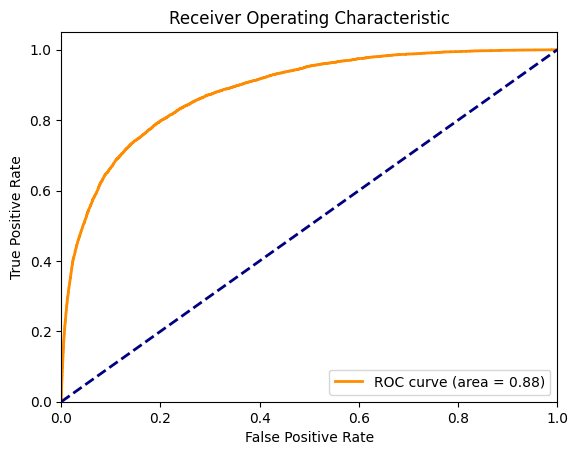

Optimal threshold: 0.6865396499633789


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1419
False Positives: 2882
False Negatives: 374
True Negatives: 5657
Total samples: 10332
For pos_weight: 4.8 ---> Test Loss: 0.9978, Test Accuracy: 0.6849, Precision: 0.3299, Recall: 0.7914, F1 Score: 0.4657
For pos_w: 4.7


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.3301
Epoch [1/20], Batch [10/17], Loss: 1.1444
Epoch [1/20], Batch [15/17], Loss: 1.1314
Epoch 1/20, Loss: 1.3238
Epoch [2/20], Batch [5/17], Loss: 1.0622
Epoch [2/20], Batch [10/17], Loss: 1.0972
Epoch [2/20], Batch [15/17], Loss: 1.0842
Epoch 2/20, Loss: 1.1205
Epoch [3/20], Batch [5/17], Loss: 1.1621
Epoch [3/20], Batch [10/17], Loss: 1.1114
Epoch [3/20], Batch [15/17], Loss: 1.0638
Epoch 3/20, Loss: 1.1031
Epoch [4/20], Batch [5/17], Loss: 1.1293
Epoch [4/20], Batch [10/17], Loss: 1.0890
Epoch [4/20], Batch [15/17], Loss: 1.1366
Epoch 4/20, Loss: 1.0831
Epoch [5/20], Batch [5/17], Loss: 1.0631
Epoch [5/20], Batch [10/17], Loss: 1.0663
Epoch [5/20], Batch [15/17], Loss: 1.0889
Epoch 5/20, Loss: 1.0694
Epoch [6/20], Batch [5/17], Loss: 1.0387
Epoch [6/20], Batch [10/17], Loss: 1.0707
Epoch [6/20], Batch [15/17], Loss: 1.0721
Epoch 6/20, Loss: 1.0551
Epoch [7/20], Batch [5/17], Loss: 1.0456
Epoch [7/20], Batch [10/17], Loss: 1.0404
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


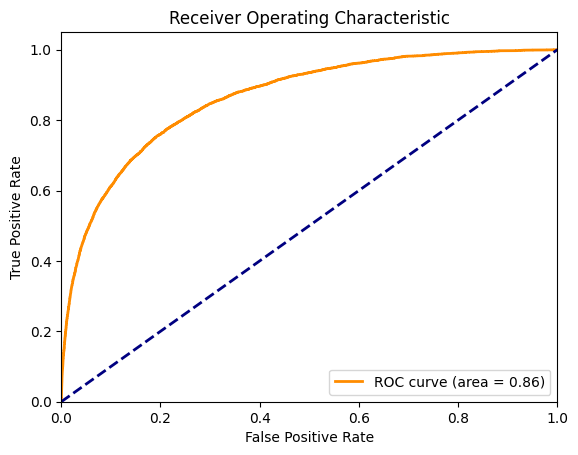

Optimal threshold: 0.6323995590209961


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1404
False Positives: 2908
False Negatives: 389
True Negatives: 5631
Total samples: 10332
For pos_weight: 4.7 ---> Test Loss: 0.9500, Test Accuracy: 0.6809, Precision: 0.3256, Recall: 0.7830, F1 Score: 0.4600
For pos_w: 4.6


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.4116
Epoch [1/20], Batch [10/17], Loss: 1.3169
Epoch [1/20], Batch [15/17], Loss: 1.2050
Epoch 1/20, Loss: 1.4516
Epoch [2/20], Batch [5/17], Loss: 1.1556
Epoch [2/20], Batch [10/17], Loss: 1.1254
Epoch [2/20], Batch [15/17], Loss: 1.0745
Epoch 2/20, Loss: 1.1356
Epoch [3/20], Batch [5/17], Loss: 1.1267
Epoch [3/20], Batch [10/17], Loss: 1.0823
Epoch [3/20], Batch [15/17], Loss: 1.0364
Epoch 3/20, Loss: 1.0885
Epoch [4/20], Batch [5/17], Loss: 1.0304
Epoch [4/20], Batch [10/17], Loss: 1.1795
Epoch [4/20], Batch [15/17], Loss: 1.0991
Epoch 4/20, Loss: 1.0690
Epoch [5/20], Batch [5/17], Loss: 1.0845
Epoch [5/20], Batch [10/17], Loss: 1.0308
Epoch [5/20], Batch [15/17], Loss: 1.0818
Epoch 5/20, Loss: 1.0565
Epoch [6/20], Batch [5/17], Loss: 1.0045
Epoch [6/20], Batch [10/17], Loss: 1.0210
Epoch [6/20], Batch [15/17], Loss: 1.0550
Epoch 6/20, Loss: 1.0416
Epoch [7/20], Batch [5/17], Loss: 1.0220
Epoch [7/20], Batch [10/17], Loss: 1.0901
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


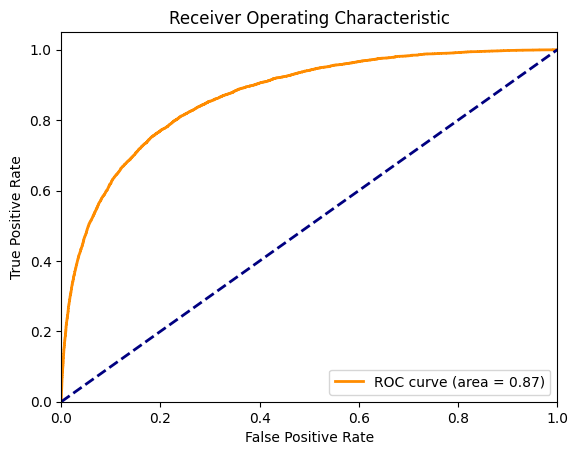

Optimal threshold: 0.5331490635871887


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1423
False Positives: 2919
False Negatives: 370
True Negatives: 5620
Total samples: 10332
For pos_weight: 4.6 ---> Test Loss: 0.8902, Test Accuracy: 0.6817, Precision: 0.3277, Recall: 0.7936, F1 Score: 0.4639
For pos_w: 4.5


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.5601
Epoch [1/20], Batch [10/17], Loss: 1.1243
Epoch [1/20], Batch [15/17], Loss: 1.0667
Epoch 1/20, Loss: 1.4205
Epoch [2/20], Batch [5/17], Loss: 1.1146
Epoch [2/20], Batch [10/17], Loss: 1.1433
Epoch [2/20], Batch [15/17], Loss: 1.1132
Epoch 2/20, Loss: 1.1447
Epoch [3/20], Batch [5/17], Loss: 1.1269
Epoch [3/20], Batch [10/17], Loss: 1.0795
Epoch [3/20], Batch [15/17], Loss: 1.0860
Epoch 3/20, Loss: 1.0986
Epoch [4/20], Batch [5/17], Loss: 1.1213
Epoch [4/20], Batch [10/17], Loss: 1.0424
Epoch [4/20], Batch [15/17], Loss: 1.1284
Epoch 4/20, Loss: 1.0849
Epoch [5/20], Batch [5/17], Loss: 1.0730
Epoch [5/20], Batch [10/17], Loss: 1.0374
Epoch [5/20], Batch [15/17], Loss: 1.0378
Epoch 5/20, Loss: 1.0671
Epoch [6/20], Batch [5/17], Loss: 1.0588
Epoch [6/20], Batch [10/17], Loss: 1.0774
Epoch [6/20], Batch [15/17], Loss: 1.0144
Epoch 6/20, Loss: 1.0488
Epoch [7/20], Batch [5/17], Loss: 1.0759
Epoch [7/20], Batch [10/17], Loss: 1.0053
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


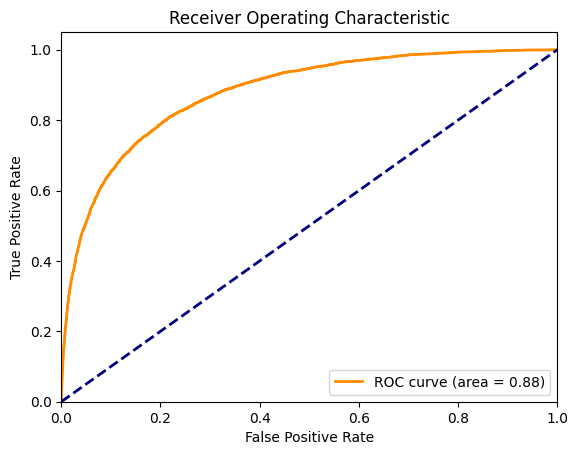

Optimal threshold: 0.5705457329750061


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1397
False Positives: 2819
False Negatives: 396
True Negatives: 5720
Total samples: 10332
For pos_weight: 4.5 ---> Test Loss: 0.8996, Test Accuracy: 0.6888, Precision: 0.3314, Recall: 0.7791, F1 Score: 0.4650
For pos_w: 4.4


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 2.4800
Epoch [1/20], Batch [10/17], Loss: 1.0992
Epoch [1/20], Batch [15/17], Loss: 1.1545
Epoch 1/20, Loss: 1.5940
Epoch [2/20], Batch [5/17], Loss: 1.1905
Epoch [2/20], Batch [10/17], Loss: 1.1085
Epoch [2/20], Batch [15/17], Loss: 1.1159
Epoch 2/20, Loss: 1.1374
Epoch [3/20], Batch [5/17], Loss: 1.0669
Epoch [3/20], Batch [10/17], Loss: 1.1172
Epoch [3/20], Batch [15/17], Loss: 1.1311
Epoch 3/20, Loss: 1.1004
Epoch [4/20], Batch [5/17], Loss: 1.0606
Epoch [4/20], Batch [10/17], Loss: 1.0779
Epoch [4/20], Batch [15/17], Loss: 1.0916
Epoch 4/20, Loss: 1.0835
Epoch [5/20], Batch [5/17], Loss: 1.0589
Epoch [5/20], Batch [10/17], Loss: 1.0206
Epoch [5/20], Batch [15/17], Loss: 1.0441
Epoch 5/20, Loss: 1.0740
Epoch [6/20], Batch [5/17], Loss: 1.0865
Epoch [6/20], Batch [10/17], Loss: 1.0445
Epoch [6/20], Batch [15/17], Loss: 1.1329
Epoch 6/20, Loss: 1.0591
Epoch [7/20], Batch [5/17], Loss: 0.9880
Epoch [7/20], Batch [10/17], Loss: 1.0961
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


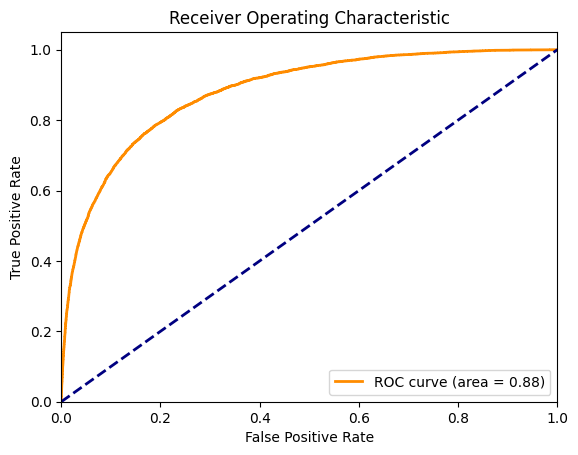

Optimal threshold: 0.5569521188735962


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1422
False Positives: 2839
False Negatives: 371
True Negatives: 5700
Total samples: 10332
For pos_weight: 4.4 ---> Test Loss: 0.8922, Test Accuracy: 0.6893, Precision: 0.3337, Recall: 0.7931, F1 Score: 0.4698
For pos_w: 4.3


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.7818
Epoch [1/20], Batch [10/17], Loss: 1.4934
Epoch [1/20], Batch [15/17], Loss: 1.2461
Epoch 1/20, Loss: 1.4071
Epoch [2/20], Batch [5/17], Loss: 1.1135
Epoch [2/20], Batch [10/17], Loss: 1.1052
Epoch [2/20], Batch [15/17], Loss: 1.1017
Epoch 2/20, Loss: 1.1552
Epoch [3/20], Batch [5/17], Loss: 1.1551
Epoch [3/20], Batch [10/17], Loss: 1.0905
Epoch [3/20], Batch [15/17], Loss: 1.1300
Epoch 3/20, Loss: 1.1089
Epoch [4/20], Batch [5/17], Loss: 1.1225
Epoch [4/20], Batch [10/17], Loss: 1.0883
Epoch [4/20], Batch [15/17], Loss: 1.1059
Epoch 4/20, Loss: 1.0819
Epoch [5/20], Batch [5/17], Loss: 1.0853
Epoch [5/20], Batch [10/17], Loss: 1.0434
Epoch [5/20], Batch [15/17], Loss: 1.0569
Epoch 5/20, Loss: 1.0705
Epoch [6/20], Batch [5/17], Loss: 1.1226
Epoch [6/20], Batch [10/17], Loss: 1.0272
Epoch [6/20], Batch [15/17], Loss: 1.0828
Epoch 6/20, Loss: 1.0624
Epoch [7/20], Batch [5/17], Loss: 1.0670
Epoch [7/20], Batch [10/17], Loss: 1.0919
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


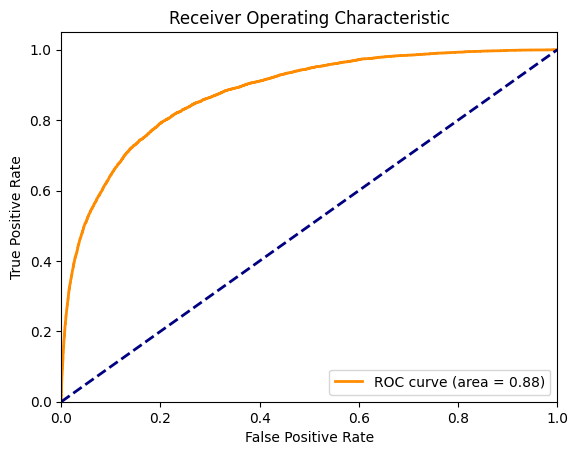

Optimal threshold: 0.636608898639679


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1386
False Positives: 2764
False Negatives: 407
True Negatives: 5775
Total samples: 10332
For pos_weight: 4.3 ---> Test Loss: 0.9336, Test Accuracy: 0.6931, Precision: 0.3340, Recall: 0.7730, F1 Score: 0.4664
For pos_w: 4.2


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 2.2398
Epoch [1/20], Batch [10/17], Loss: 1.3277
Epoch [1/20], Batch [15/17], Loss: 1.2684
Epoch 1/20, Loss: 1.5669
Epoch [2/20], Batch [5/17], Loss: 1.1767
Epoch [2/20], Batch [10/17], Loss: 1.1794
Epoch [2/20], Batch [15/17], Loss: 1.1013
Epoch 2/20, Loss: 1.1649
Epoch [3/20], Batch [5/17], Loss: 1.0824
Epoch [3/20], Batch [10/17], Loss: 1.0812
Epoch [3/20], Batch [15/17], Loss: 1.0632
Epoch 3/20, Loss: 1.1017
Epoch [4/20], Batch [5/17], Loss: 1.0723
Epoch [4/20], Batch [10/17], Loss: 1.0944
Epoch [4/20], Batch [15/17], Loss: 1.0935
Epoch 4/20, Loss: 1.0803
Epoch [5/20], Batch [5/17], Loss: 1.0588
Epoch [5/20], Batch [10/17], Loss: 1.1204
Epoch [5/20], Batch [15/17], Loss: 1.1185
Epoch 5/20, Loss: 1.0771
Epoch [6/20], Batch [5/17], Loss: 1.0457
Epoch [6/20], Batch [10/17], Loss: 1.1003
Epoch [6/20], Batch [15/17], Loss: 1.0055
Epoch 6/20, Loss: 1.0587
Epoch [7/20], Batch [5/17], Loss: 0.9985
Epoch [7/20], Batch [10/17], Loss: 1.0347
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


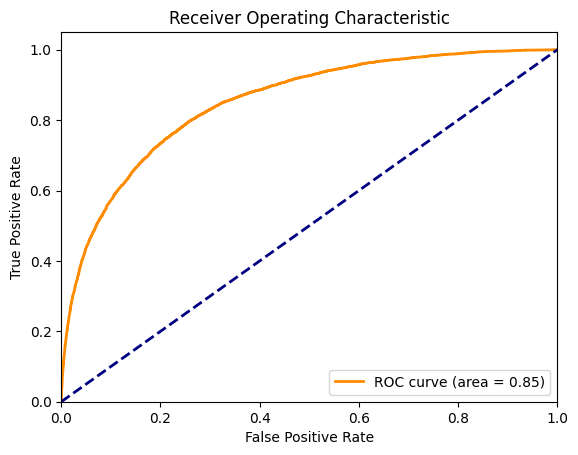

Optimal threshold: 0.5423328280448914


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1508
False Positives: 3550
False Negatives: 285
True Negatives: 4989
Total samples: 10332
For pos_weight: 4.2 ---> Test Loss: 0.9234, Test Accuracy: 0.6288, Precision: 0.2981, Recall: 0.8410, F1 Score: 0.4402
For pos_w: 4.1


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.5837
Epoch [1/20], Batch [10/17], Loss: 1.1596
Epoch [1/20], Batch [15/17], Loss: 1.1879
Epoch 1/20, Loss: 1.3375
Epoch [2/20], Batch [5/17], Loss: 1.1750
Epoch [2/20], Batch [10/17], Loss: 1.1373
Epoch [2/20], Batch [15/17], Loss: 1.1451
Epoch 2/20, Loss: 1.1198
Epoch [3/20], Batch [5/17], Loss: 1.0627
Epoch [3/20], Batch [10/17], Loss: 1.0610
Epoch [3/20], Batch [15/17], Loss: 1.1017
Epoch 3/20, Loss: 1.0868
Epoch [4/20], Batch [5/17], Loss: 1.0617
Epoch [4/20], Batch [10/17], Loss: 1.0424
Epoch [4/20], Batch [15/17], Loss: 1.0203
Epoch 4/20, Loss: 1.0701
Epoch [5/20], Batch [5/17], Loss: 1.0953
Epoch [5/20], Batch [10/17], Loss: 1.0277
Epoch [5/20], Batch [15/17], Loss: 1.0123
Epoch 5/20, Loss: 1.0533
Epoch [6/20], Batch [5/17], Loss: 1.0553
Epoch [6/20], Batch [10/17], Loss: 0.9784
Epoch [6/20], Batch [15/17], Loss: 1.0634
Epoch 6/20, Loss: 1.0376
Epoch [7/20], Batch [5/17], Loss: 0.9948
Epoch [7/20], Batch [10/17], Loss: 1.0139
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


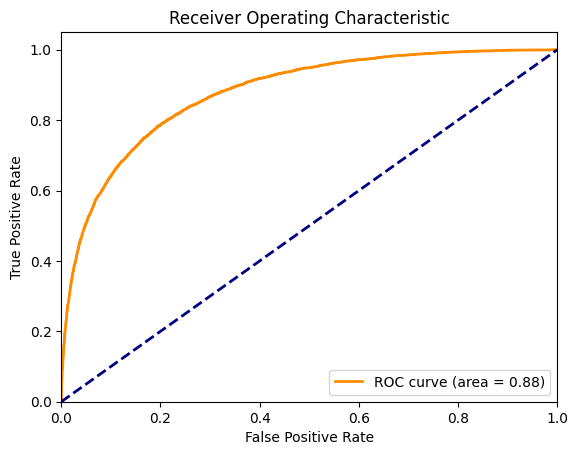

Optimal threshold: 0.4868461787700653


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1444
False Positives: 3010
False Negatives: 349
True Negatives: 5529
Total samples: 10332
For pos_weight: 4.1 ---> Test Loss: 0.8778, Test Accuracy: 0.6749, Precision: 0.3242, Recall: 0.8054, F1 Score: 0.4623
For pos_w: 4.0


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Batch [5/17], Loss: 1.4096
Epoch [1/20], Batch [10/17], Loss: 1.2956
Epoch [1/20], Batch [15/17], Loss: 1.1463
Epoch 1/20, Loss: 1.3568
Epoch [2/20], Batch [5/17], Loss: 1.1765
Epoch [2/20], Batch [10/17], Loss: 1.0774
Epoch [2/20], Batch [15/17], Loss: 1.1043
Epoch 2/20, Loss: 1.1382
Epoch [3/20], Batch [5/17], Loss: 1.1055
Epoch [3/20], Batch [10/17], Loss: 1.0797
Epoch [3/20], Batch [15/17], Loss: 0.9968
Epoch 3/20, Loss: 1.0853
Epoch [4/20], Batch [5/17], Loss: 1.0399
Epoch [4/20], Batch [10/17], Loss: 1.0653
Epoch [4/20], Batch [15/17], Loss: 1.0967
Epoch 4/20, Loss: 1.0609
Epoch [5/20], Batch [5/17], Loss: 1.0830
Epoch [5/20], Batch [10/17], Loss: 0.9879
Epoch [5/20], Batch [15/17], Loss: 1.0342
Epoch 5/20, Loss: 1.0459
Epoch [6/20], Batch [5/17], Loss: 1.0304
Epoch [6/20], Batch [10/17], Loss: 1.0794
Epoch [6/20], Batch [15/17], Loss: 1.0510
Epoch 6/20, Loss: 1.0380
Epoch [7/20], Batch [5/17], Loss: 0.9803
Epoch [7/20], Batch [10/17], Loss: 1.0608
Epoch [7/20], Bat

/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


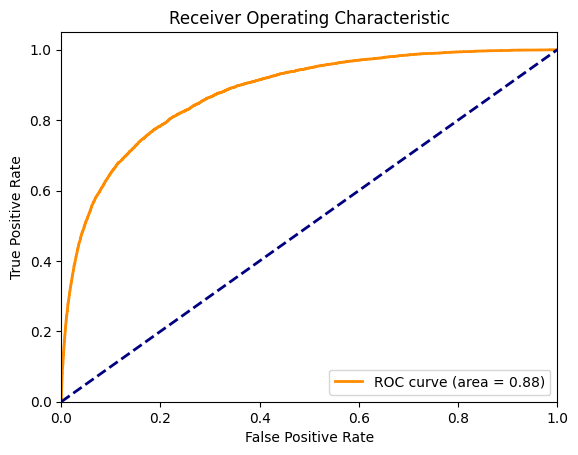

Optimal threshold: 0.6985558867454529


/project/msoleyma_1026/ecp/ecp-venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


True Positives: 1258
False Positives: 2019
False Negatives: 535
True Negatives: 6520
Total samples: 10332
For pos_weight: 4.0 ---> Test Loss: 0.9304, Test Accuracy: 0.7528, Precision: 0.3839, Recall: 0.7016, F1 Score: 0.4963


In [14]:
pos_ws = [4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2, 4.1, 4.0]
for pos_w in pos_ws:   
    print(f"For pos_w: {pos_w}") 
    input_size = 5127
    hidden_size = 4096
    num_classes = 1
    lr = 1e-5
    batch_size = 64
    num_epochs = 20
    num_layers = 3
    print_interval = 5

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
    embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/concatenated/train'

    train_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='train')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)

    model = PairDetector(input_size, hidden_size, num_classes, n_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  
    # criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).float()) 

    total_loss = 0.0
    total_batches = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss_emotion = 0.0
        num_batches = 0
        for batch_idx, (inputs, labels, convID, utterancePairs) in enumerate(train_loader):
            inputs = inputs.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()

            active_outputs = outputs[labels != -1]
            active_pairs = labels[labels != -1]
            loss = criterion(active_outputs, active_pairs)
            loss.backward()
            optimizer.step()

            epoch_loss_emotion += loss.item()
            total_loss += loss.item()
            total_batches += 1
            # print(loss.item())

            if (batch_idx + 1) % print_interval == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], '
                    f'Loss: {loss.item():.4f}')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_emotion / len(train_loader):.4f}")

    overall_avg_loss = total_loss / total_batches
    print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

    model_path = "/project/msoleyma_1026/ecp/models/pair_detection_model_early" + str(pos_w) + ".pt"
    torch.save(model.state_dict(), model_path)

    pairs_labels_file_roc = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_train.json'
    embeddings_dir_roc = '/project/msoleyma_1026/ecp/data/pair_embeddings/concatenated/train'
    train_dataset_roc = PairDataset(pairs_labels_file_roc, embeddings_dir_roc, mode='train')
    train_loader_roc = DataLoader(train_dataset_roc, batch_size=batch_size, shuffle=True, collate_fn=debug_collate_fn)
    
    scores, labels = evaluate_model_for_roc(model, train_loader_roc, device)

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate the optimal threshold: the one with the highest tpr - fpr
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal threshold:', optimal_threshold)

    def evaluate_model(model, dataloader, criterion):
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        with torch.no_grad():
            for batch in dataloader:
                context_embeddings, target_pairs, conversation_ids, utterance_ids = batch
                
                context_embeddings = context_embeddings.to(device)
                target_pairs = target_pairs.to(device)

                output = model(context_embeddings)

                target_pairs = target_pairs.squeeze()

                active_outputs = output[target_pairs != -1]
                active_pairs = target_pairs[target_pairs != -1]
                loss = criterion(active_outputs, active_pairs)

                total_loss += loss.item()
                sigmoid_output = torch.sigmoid(active_outputs)

                threshold = optimal_threshold #calculated using ROC
                # threshold = 0.5
                binary_predictions = (sigmoid_output >= threshold).float()

                correct_predictions = (binary_predictions == active_pairs)
                # correct_predictions = correct_predictions[target_pairs != -1]
                
                total_correct += correct_predictions.sum().item()
                total_samples += active_pairs.size(0)

                # Calculate TP, FP, FN
                TP += ((binary_predictions == 1) & (active_pairs == 1)).sum().item()
                FP += ((binary_predictions == 1) & (active_pairs == 0)).sum().item()
                FN += ((binary_predictions == 0) & (active_pairs == 1)).sum().item()
                TN += ((binary_predictions == 0) & (active_pairs == 0)).sum().item()

                # Store conversation and utterance IDs along with predicted emotions
                # for i in range(len(conversation_ids)):
                #     conv_id = conversation_ids[i]
                #     utter_id = utterance_ids[i]
                #     prediction = binary_predictions[i].tolist()
                #     predictions[(conv_id, utter_id)] = tuple(prediction)

        print(f"True Positives: {TP}")
        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Negatives: {TN}")
        print(f"Total samples: {total_samples}")

        average_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return average_loss, accuracy, precision, recall, f1_score

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pairs_labels_file = '/project/msoleyma_1026/ecp/data/utterance_pairs_emotion_flags_test.json'
    embeddings_dir = '/project/msoleyma_1026/ecp/data/pair_embeddings/concatenated/test'

    test_dataset = PairDataset(pairs_labels_file, embeddings_dir, mode='eval')

    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=debug_collate_fn)

    val_loss, val_accuracy, val_precision, val_recall, val_f1_score = evaluate_model(model, test_dataloader, criterion)
    print(f'For pos_weight: {pos_w} ---> Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1_score:.4f}')